In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp

from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'gpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd

0.4.14
3.11.6
1.11.3


In [2]:
n_col =19
n_row = n_col
x_span = 19
y_span = 19

# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
zs =  0.05*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)
zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.25
E = 24855578.*1e-3
nu = 0.2
design_nodes = []
non_design_nodes = []
for i in range(n_node):
    if xs[i] != 0 and xs[i] != x_span:#[xs[i],ys[i]]!= [0,0] and [xs[i],ys[i]] != [0,y_span] and [xs[i],ys[i]] != [x_span,y_span] and [xs[i],ys[i]] != [x_span,0]:
        design_nodes.append(i)
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500*400/n_node

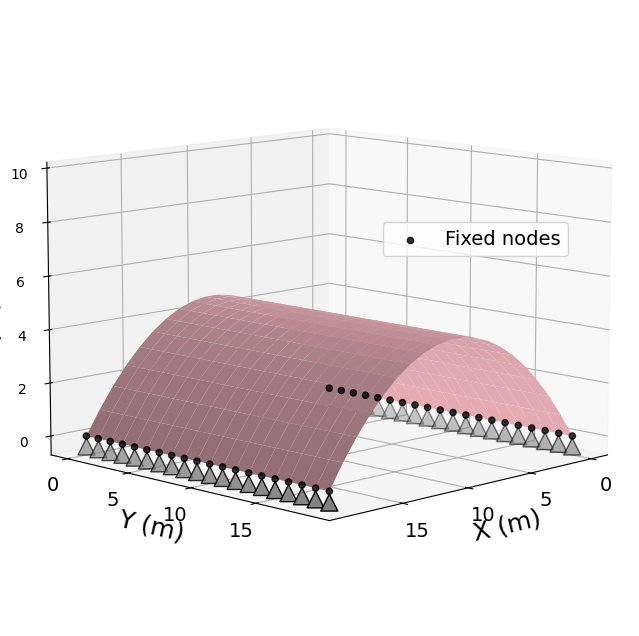

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

In [4]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()

2024-03-13 14:56:47.570903: I external/xla/xla/pjrt/tfrt_cpu_pjrt_client.cc:462] TfrtCpuClient created.
2024-03-13 14:56:47.697141: I external/xla/xla/service/service.cc:168] XLA service 0x564740f01ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 14:56:47.697165: I external/xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-13 14:56:47.697494: I external/xla/xla/pjrt/gpu/se_gpu_pjrt_client.cc:633] Using BFC allocator.
2024-03-13 14:56:47.697554: I external/xla/xla/pjrt/gpu/gpu_helpers.cc:105] XLA backend allocating 63875432448 bytes on device 0 for BFCAllocator.
2024-03-13 14:56:47.911638: I external/xla/xla/stream_executor/cuda/cuda_dnn.cc:440] Loaded cuDNN version 8800
2024-03-13 14:56:47.915226: I external/tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 14:56:47.916986: I external/tsl/tsl/platform/def

In [5]:
model.solve(which_solver='dense')
uz = model.u[design_nodes*6+2]
print(np.min(uz))

-25.012605702635245


In [6]:
model.solve(which_solver='sparse',enforce_scipy_sparse=True)
uz = model.u[design_nodes*6+2]
print(np.min(uz))

-25.012605703354012


In [7]:
model.solve(which_solver='sparse',enforce_scipy_sparse=False)
uz = model.u[design_nodes*6+2]
print(np.min(uz))

-25.0126057024101


In [8]:
print(0.5*model.u@model.get_loads())

1229701.7817546


In [9]:
(1231.245-1229.7017813672578)/1231.245

0.0012533806291534849

In [10]:
(0.025012605701995316-0.025351)/0.025351

-0.01334836093269229

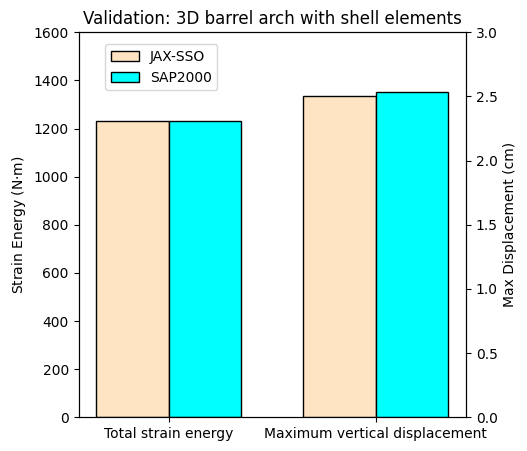

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Data for strain energy and maximum displacement for solver A and solver B
strain_energy_A = 1229.7017813672578
strain_energy_B = 1231.245
max_displacement_A = 0.025012605701995316*100
max_displacement_B = 0.025351*100


# Labels for the bars
labels = ['Total strain energy', 'Maximum vertical displacement']

# Positions of the bars on the x-axis
x = np.arange(len(labels))

# Width of the bars
width = 0.35

# Create figure and axis objects
fig, ax1 = plt.subplots(figsize=(5,5))

# Create the first bar plot for strain energy on the first axis
ax1.bar([0 - width/2], [strain_energy_A], width, label='JAX-SSO',edgecolor = "black", color='bisque')
ax1.bar([0 + width/2], [strain_energy_B], width, label='SAP2000',edgecolor = "black", color='cyan')
ax1.set_ylabel(r'Strain Energy (N$\cdot$m)')
ax1.set_ylim(0,1600)

# Create the second axis sharing the same x-axis
ax2 = ax1.twinx()

# Create the second bar plot for maximum displacement on the second axis
ax2.bar([1 - width/2], [max_displacement_A], width,edgecolor = "black", color='bisque')
ax2.bar([1 + width/2], [max_displacement_B], width,edgecolor = "black", color='cyan')
ax2.set_ylabel('Max Displacement (cm)')
ax2.set_ylim(0,3)

# Set x-axis ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Add legend
fig.legend(loc=(0.2,0.8))

# Show plot
plt.title('Validation: 3D barrel arch with shell elements')
plt.show()

# Seems like "singular matrix" error of jax.spsolve happens sometimes

1. Happened: E = 24855578. -> min (u) = -0.025
2. Does not happen:  E = 2485557 ->  min (u) = -0.2501281588016551

Unit problem--> Stiffness matrix too large?

When 199 times 199 nodes, dense fails while sparse still works


Output nodal coordinates and connectivity

In [ ]:
df1 = pd.DataFrame(cnct)
df1.to_csv('Cnct_shell.csv')
crds = model.get_node_crds()
df2  = pd.DataFrame(crds)
df2.to_csv('Cnct_crds.csv')

# SAP 2000 results

Max displacement: -0.025368 m;
Strain energy:1231.128 KN*m